In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
LOCAL_FAST_AI = '/Users/krishnakalyan3/Educational/FastAI/fastai/'
AWS_FAST_AI = '/home/ubuntu/fastai'
sys.path.append(AWS_FAST_AI)

In [3]:
from fastai.imports import *
from glob import iglob
import pprint 
from fastai.transforms import * 
from fastai.conv_learner import * 
from fastai.model import *
from fastai.dataset import * 
from fastai.sgdr import *
from fastai.plots import *
from fastai.models.nasnet import nasnetalarge

PATH = '/home/ubuntu/Plant/data/'

Create Label File

Train Model

In [6]:
label_csv = f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)
n

4750

In [7]:
f_model = resnext50
sz=250
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)

In [8]:
data = ImageClassifierData.from_csv(PATH, folder='train', csv_fname=f'{PATH}labels.csv',
                                    tfms=tfms, val_idxs=val_idxs, test_name='test', bs=12)
learn = ConvLearner.pretrained(f_model, data, precompute=True)

100%|██████████| 67/67 [00:11<00:00,  5.93it/s]


In [9]:
learn.fit(0.01, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.05343  0.54183  0.81979]                        



HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 73%|███████▎  | 231/317 [00:01<00:00, 130.17it/s, loss=2.96] 


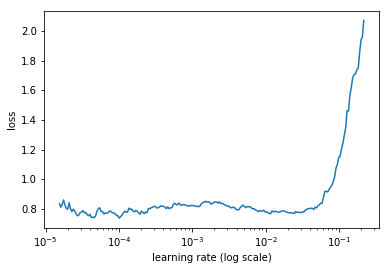

In [10]:
lrf=learn.lr_find()
learn.sched.plot()

In [11]:
lr = 1e-2
learn.unfreeze()
lr=np.array([lr/18,lr/6,lr/2])
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.81384  0.41725  0.85938]                        
[ 1.       0.72015  0.38186  0.875  ]                        
[ 2.       0.65839  0.36713  0.87396]                        
[ 3.       0.70971  0.38933  0.85938]                        
[ 4.       0.59988  0.34959  0.87813]                        
[ 5.       0.59358  0.31362  0.8875 ]                        
[ 6.       0.52244  0.30947  0.88542]                        



In [12]:
learn.fit(lr, 3, cycle_len=2, cycle_mult=4)

HBox(children=(IntProgress(value=0, description='Epoch', max=42), HTML(value='')))

[ 0.       0.60965  0.31667  0.88854]                        
[ 1.       0.57743  0.3191   0.89062]                        
[ 2.       0.58759  0.33475  0.87396]                        
[ 3.       0.54904  0.29814  0.89375]                        
[ 4.       0.55493  0.30723  0.8875 ]                        
[ 5.       0.49095  0.30741  0.88646]                        
[ 6.       0.46271  0.29119  0.89583]                        
[ 7.       0.46768  0.28594  0.90104]                        
[ 8.       0.40585  0.27577  0.90312]                        
[ 9.       0.39704  0.27961  0.89792]                        
[ 10.        0.48966   0.30703   0.89271]                    
[ 11.        0.47799   0.30149   0.89687]                    
[ 12.        0.45683   0.29768   0.89687]                    
[ 13.        0.46646   0.30406   0.88438]                    
[ 14.        0.4985    0.29721   0.90417]                    
[ 15.        0.49217   0.28522   0.9    ]                    
[ 16.   

In [15]:
learn.save(f'resnext_50_250')

Metrics

In [16]:
def metrics(y, yhat):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    from sklearn.metrics import accuracy_score
    cm = confusion_matrix(y, yhat)
    f1 = f1_score(y, yhat, average='macro')
    acc = accuracy_score(y, yhat)

    # plt.matshow(cm)
    return f1, acc, cm

In [17]:
log_preds,y = learn.TTA()

In [26]:
lp = np.mean(log_preds, axis=0)
lp_prob = np.exp(lp)
yhat_train = np.argmax(lp_prob, axis=1)

In [27]:
yhat_train.shape

(950,)

In [28]:
y.shape

(950,)

In [29]:
metrics(y, yhat_train)

(0.92739887804248122,
 0.93684210526315792,
 array([[ 30,   0,   0,   0,   0,   0,  16,   0,   0,   0,   0,   0],
        [  0,  89,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,  45,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 118,   0,   1,   0,   0,   3,   0,   0,   0],
        [  1,   0,   0,   1,  39,   0,   0,   1,   0,   0,   0,   0],
        [  0,   1,   0,   1,   0,  90,   0,   0,   0,   0,   0,   1],
        [ 12,   0,   0,   0,   0,   0, 119,   0,   0,   0,   0,   0],
        [  0,   1,   0,   0,   0,   0,   0,  50,   2,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,  93,   0,   0,   0],
        [  0,   0,   0,   2,   0,   0,   0,   0,   7,  38,   1,   0],
        [  1,   0,   0,   0,   0,   0,   1,   0,   0,   0, 101,   0],
        [  1,   0,   0,   1,   0,   3,   0,   0,   0,   0,   0,  78]]))

In [30]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(793, 12)

In [41]:
lp_prob_test = np.exp(log_preds_test)
yhat_test = np.argmax(lp_prob_test, axis=1)

In [45]:
PATH

'/home/ubuntu/Plant/data/'

In [50]:
preds_classes = [data.classes[i].replace("_", " ") for i in yhat_test]
#submission = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'species': preds_classes})

In [49]:
#submission.to_csv(PATH + 'submission_10.csv', index=False)